# Statistics on Results

## Locked New

### .txt into .parquet

In [6]:
import pandas as pd
import os

input_directory = "C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\RAW_Data_New"
output_directory = "C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetDataNew"

# Sicherstellen, dass das Zielverzeichnis existiert
if not os.path.exists(output_directory):
    print(f"Das Verzeichnis {output_directory} existiert nicht. Es wird nun erstellt.")
    os.makedirs(output_directory)

# Alle .txt-Dateien im Verzeichnis finden
txt_files = [f for f in os.listdir(input_directory) if f.endswith(".txt")]

# Durch alle .txt-Dateien im Verzeichnis gehen
for txt_file in txt_files:
    # Pfad zur aktuellen .txt-Datei
    input_file = os.path.join(input_directory, txt_file)
    
    # CSV-Zwischenspeicherung im Input-Ordner (optional)
    csv_file_name = txt_file.replace(".txt", ".csv")
    csv_path = os.path.join(input_directory, csv_file_name)

    # Parquet-Dateiname im Output-Ordner
    parquet_file_name = txt_file.replace(".txt", ".parquet")
    parquet_path = os.path.join(output_directory, parquet_file_name)

    # .txt-Datei einlesen, wobei die ersten 4 Zeilen übersprungen werden
    try:
        df = pd.read_csv(input_file, skiprows=4)
        
        # Als CSV speichern (optional, im Input-Ordner)
        df.to_csv(csv_path, index=False)
        print(f"{txt_file} wurde als CSV gespeichert: {csv_path}")

        # Als Parquet speichern (im Output-Ordner)
        df.to_parquet(parquet_path, index=False)
        print(f"{txt_file} wurde als Parquet gespeichert: {parquet_path}")
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {txt_file}: {e}")


OFD_C_729_locked_TA_3.txt wurde als CSV gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\RAW_Data_New\OFD_C_729_locked_TA_3.csv
OFD_C_729_locked_TA_3.txt wurde als Parquet gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetDataNew\OFD_C_729_locked_TA_3.parquet


### Converting into frequency and PSD - doing FF and using convertion factor

In [7]:
import os
import numpy as np
import pandas as pd

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Sicherstellen, dass f nie 0 ist
    return A * f_safe**(-B)

def process_parquet_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for file in os.listdir(input_folder):
        if file.endswith(".parquet"):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)
            
            try:
                data = pd.read_parquet(input_path)
            except Exception as e:
                print(f"Fehler beim Einlesen von {file}: {e}")
                continue
            
            time = data.iloc[:, 0].values  # Zeit
            sig = data.iloc[:, 1].values  # Signal
            
            # Parameter für Spektrale Leistungsdichte
            zff = 1
            coeff_VHz = 0.576e-6
            print(f'Conversion V/Hz : {coeff_VHz * 1e6:.4f} V/MHz')
            
            # FFT-Länge berechnen
            fft_length = int(2**(np.floor(np.log2(len(sig))) + zff))
            
            spc = np.abs(np.fft.rfft(np.blackman(len(time)) * (sig / -coeff_VHz), fft_length)) / len(time)
            freq = np.fft.rfftfreq(fft_length, np.mean(np.diff(time)))
            
            psds = 2 * spc**2 / (
                np.sum(np.blackman(len(time))**2) 
                / (len(sig)**2 * np.mean(np.diff(time)))
            )
            
            # Daten in DataFrame speichern und als Parquet exportieren
            result_df = pd.DataFrame({'Frequenz (Hz)': freq, 'PSD': psds})
            result_df.to_parquet(output_path, index=False)
            print(f"Ergebnis gespeichert: {output_path}")

input_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetDataNew'
output_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetDataNew\\Parquet_locked_FF_PSD_New'

process_parquet_files(input_folder, output_folder)


Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetDataNew\Parquet_locked_FF_PSD_New\OFD_C_729_locked_TA_3.parquet


### Plot New data:

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetDataNew\Parquet_locked_FF_PSD_New...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 1.940 kHz


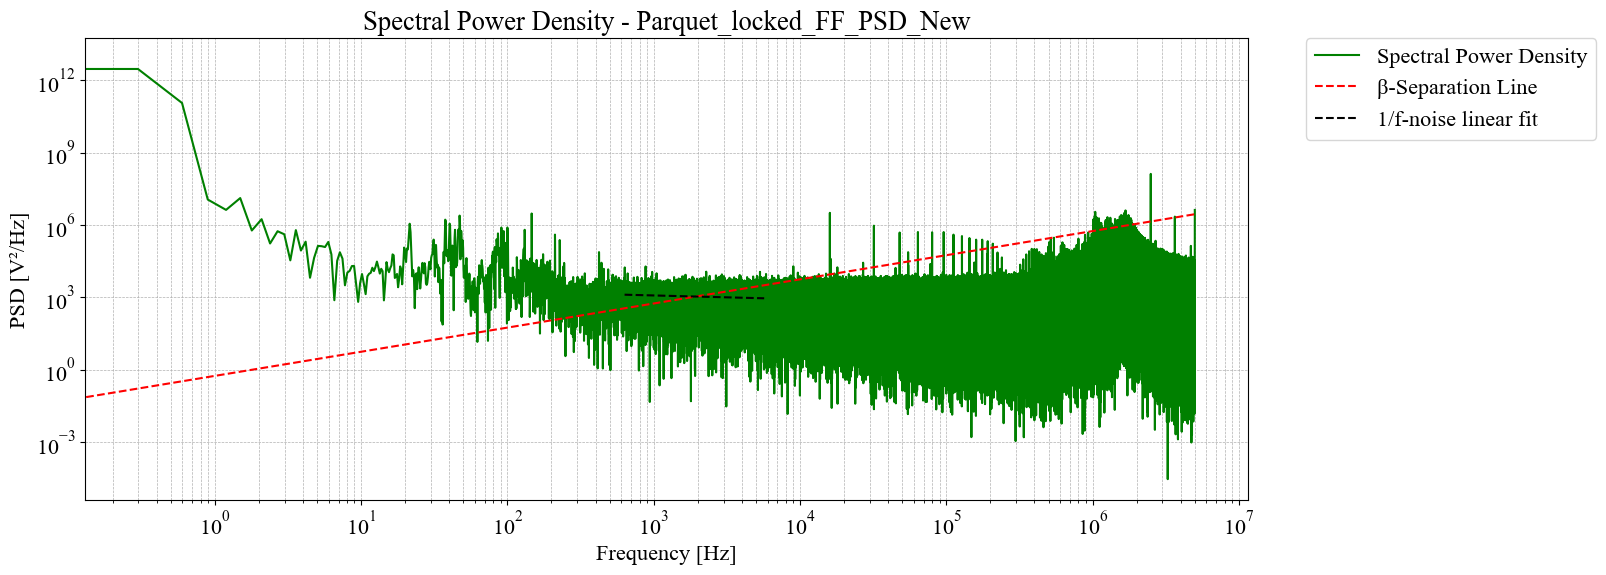

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set font properties for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Ensure f never reaches 0
    return A * f_safe**(-B)

def process_parquet_file(parquet_filename, freq_column="X", psd_column="Y"):
    try:
        # Read Parquet file
        data = pd.read_parquet(parquet_filename)
    except Exception as e:
        print(f"Error reading {parquet_filename}: {e}")
        return

    # Extract frequency and PSD columns
    if freq_column not in data.columns or psd_column not in data.columns:
        print(f"Columns '{freq_column}' and/or '{psd_column}' not found in {parquet_filename}.")
        return
    
    global freq_locked_new
    freq_locked_new = data[freq_column].values  # Frequency axis (X)
    global psds_locked_new
    psds_locked_new = data[psd_column].values   # Power spectral density (Y)

    print(f'Processing {parquet_filename}...')

    # Compute the β-separation line
    global beta_sep_full_new
    beta_sep_full_new = (8 * np.log(2) / (np.pi**2)) * freq_locked_new

    # Define fitting range for 1/f noise (select relevant frequency region)
    idx = np.where((freq_locked_new > 632) & (psds_locked_new < 4e7) & (freq_locked_new < 5690))

    freq_idx = freq_locked_new[idx[0]]
    psds_idx = psds_locked_new[idx[0]]

    if len(freq_idx) == 0 or len(psds_idx) == 0:
        print("No valid data points for curve fitting.")
        return

    # Curve fitting with power law (1/f noise)
    try:
        popt_ps, _ = curve_fit(
            power_law, freq_idx, psds_idx, 
            p0=[1e6, 1],  # Initial values
            bounds=([1e-6, 0], [1e12, 5])  # Bounds for A and B
        )
    except RuntimeError:
        print("Curve fitting failed.")
        return

    # Compute fitted curve
    fit_curve = power_law(freq_idx, *popt_ps)

    # Compute intersection with β-separation line
    beta_sep = (8 * np.log(2) / (np.pi**2)) * freq_idx
    id_crossing = np.argwhere(np.diff(np.sign(fit_curve - beta_sep))).flatten()

    if len(id_crossing) > 0:
        global cfreq_locked_new
        cfreq_locked_new = freq_idx[id_crossing][0]
        print(f'Schnittpunkt der 1/f-Kurve mit der Beta-Linie: {cfreq_locked_new * 1e-3:.3f} kHz')
    else:
        print("No intersection found.")

    # Plot spectral power density
    plt.figure(figsize=(15, 6))
    plt.loglog(freq_locked_new, psds_locked_new, label='Spectral Power Density', color='green')
    plt.loglog(freq_locked_new, beta_sep_full_new, 'r--', label='β-Separation Line')
    plt.loglog(freq_idx, fit_curve, label=f'1/f-noise linear fit', color='black', linestyle='--')



    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Spectral Power Density - {os.path.basename(parquet_filename)}')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

input_folder_data = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetDataNew\\Parquet_locked_FF_PSD_New'


# Example usage: Change the path to your folder containing Parquet files
process_parquet_file(input_folder_data, freq_column="Frequenz (Hz)", psd_column="PSD")



### Area and FHNW 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # Importing trapezoid from scipy

#achtung hier integriert von 1000Hz bis setpoint

def integrate_psd_data(freq, psds, cfreq):
    """Berechnet die Fläche unter der PSD-Kurve von 10 Hz bis cfreq"""
    
    global f_min_locked_new
    f_min_locked_new = 1000  # Untere Integrationsgrenze
    global f_max_locked_new
    f_max_locked_new = cfreq  # Obere Integrationsgrenze

    # Filter: Frequenzen und zugehörige PSD-Werte im Integrationsbereich auswählen
    mask = (freq >= f_min_locked_new) & (freq <= f_max_locked_new)
    freq_selected = freq[mask]
    psds_selected = psds[mask]

    if len(freq_selected) < 2:
        print("Nicht genügend Datenpunkte für die Integration.")
        return None

    # Integration der PSD-Daten mit der Simpson-Regel (präziser als Trapezregel)
    global A1_locked_new
    A1_locked_new = np.trapezoid(psds_selected, freq_selected)


    print(f"A1_locked (Fläche unter der PSD-Kurve von {f_min_locked_new} Hz bis {f_max_locked_new} Hz): {A1_locked_new:.3e}")
    return A1_locked_new

# Beispielaufruf mit den berechneten PSD-Werten und Frequenzen
# (freq und psds stammen aus deinem vorherigen Code!)
#cfreq = 25000  # Beispielwert für den Schnittpunkt in Hz
A1_new = integrate_psd_data(freq_locked_new, psds_locked_new, cfreq_locked_new)
print("Area A1-locked is:", A1_new)


A1_locked (Fläche unter der PSD-Kurve von 1000 Hz bis 1939.8331640938306 Hz): 1.033e+06
Area A1-locked is: 1032652.5250892763


### Calculate FWHM

In [20]:
global FWHM_locked_new
FWHM_locked_new = 1e-3 * np.sqrt(8* np.log(2) * A1_locked_new)

print("FWHM:", FWHM_locked_new, "kHz")

FWHM: 2.3929566419201835 kHz


# check PID LOCk - temperatur is as well locked but it overdrives

wavenumber: 13710,884 cm^-1
50 reps for each time point
